### Uncomment the following blocks in order to install dependencies in Google Colab

In [1]:
# !git clone https://github.com/anger232/learning-time-series-counterfactuals.git
# %cd learning-time-series-counterfactuals/ 

Cloning into 'learning-time-series-counterfactuals'...
remote: Enumerating objects: 223, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 223 (delta 38), reused 13 (delta 13), pack-reused 170
Receiving objects: 100% (223/223), 1.61 MiB | 7.44 MiB/s, done.
Resolving deltas: 100% (132/132), done.
/content/learning-time-series-counterfactuals


In [2]:
# !pip install -q wildboar
# !pip install -q scikit-learn
# !pip install -q stumpy
# !pip install -q fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 KB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
import sys
sys.path.append('./src')
sys.path.append('./LIMESegment/Utils/')

### Actual codes start

In [4]:
import logging
import os
import warnings
from argparse import ArgumentParser

from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.spatial import distance_matrix
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree, KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from wildboar.datasets import load_dataset
from wildboar.ensemble import ShapeletForestClassifier
from wildboar.explain.counterfactual import counterfactuals

from _composite import ModifiedLatentCF
from _vanilla import LatentCF
from help_functions import (ResultWriter, conditional_pad, evaluate,
                            find_best_alpha, find_best_lr, plot_graphs,
                            reset_seeds, time_series_normalize,
                            time_series_revert, upsample_minority,
                            validity_score)
from keras_models import *

In [5]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [6]:
gpu_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
os.environ['TF_DETERMINISTIC_OPS'] = '1'
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)


In [8]:
logger = logging.getLogger(__name__)
logger.info(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}.")
RANDOM_STATE = 39

DATASET_NAME = "TwoLeadECG"
OUTPUT_FILENAME = "twolead-outfile.csv"
result_writer = ResultWriter(file_name=OUTPUT_FILENAME, dataset_name=DATASET_NAME)
logger.info(f"Result writer is ready, writing to {OUTPUT_FILENAME}...")
result_writer.write_head()


In [9]:
# 1. Load data
X, y = load_dataset(DATASET_NAME, repository="wildboar/ucr")

pos = 1
neg = 2
# Convert positive and negative labels to 1 and 0
pos_label, neg_label = 1, 0
y_copy = y.copy()
if pos != pos_label:
    y_copy[y==pos] = pos_label # convert/normalize positive label to 1
if neg != neg_label:
    y_copy[y==neg] = neg_label # convert negative label to 0

X_train, X_test, y_train, y_test = train_test_split(X, y_copy, test_size=0.2, random_state=RANDOM_STATE, stratify=y_copy) 

# Upsample the minority class
y_train_copy = y_train.copy()
X_train, y_train = upsample_minority(X_train, y_train, pos_label=pos_label, neg_label=neg_label)
if y_train.shape != y_train_copy.shape:
    logger.info(f"Data upsampling performed, current distribution of y: \n{pd.value_counts(y_train)}.")


  |██████████████████████████████████████████████████| 231.83/231.83 MB


In [10]:
# ### 1.1 Normalization - fit scaler using training data 
n_training, n_timesteps = X_train.shape
n_features = 1

X_train_processed, trained_scaler = time_series_normalize(data=X_train, n_timesteps=n_timesteps)
X_test_processed, _ = time_series_normalize(data=X_test, n_timesteps=n_timesteps, scaler=trained_scaler)

X_train_processed_padded, padding_size = conditional_pad(X_train_processed) # add extra padding zeros if n_timesteps cannot be divided by 4, required for 1dCNN autoencoder structure
X_test_processed_padded, _ = conditional_pad(X_test_processed) 
n_timesteps_padded = X_train_processed_padded.shape[1]
logger.info(f"Data pre-processed, original #timesteps={n_timesteps}, padded #timesteps={n_timesteps_padded}.")


In [11]:
y_train_classes = y_train
y_test_classes = y_test

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, len(np.unique(y_train)))
y_test = to_categorical(y_test, len(np.unique(y_test)))

In [12]:
n_lstmcells = 8

# ## 2. LatentCF models
# reset seeds for numpy, tensorflow, python random package and python environment seed
reset_seeds()

###############################################
# ## 2.0 LSTM-FCN classifier
###############################################
# ### LSTM-FCN classifier
classifier = LSTMFCNClassifier(
    n_timesteps_padded, n_features, n_output=2, n_LSTM_cells=n_lstmcells
)

# optimizer = keras.optimizers.Adam(learning_rate=0.0001)
optimizer = keras.optimizers.legacy.Adam(learning_rate=0.0001)
classifier.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)

# Define the early stopping criteria
early_stopping_accuracy = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=30, restore_best_weights=True
)
# Train the model
reset_seeds()
logger.info("Training log for LSTM-FCN classifier:")
classifier_history = classifier.fit(
    X_train_processed_padded,
    y_train,
    epochs=150,
    batch_size=32,
    shuffle=True,
    verbose=True,
    validation_data=(X_test_processed_padded, y_test),
    callbacks=[early_stopping_accuracy],
)

y_pred = classifier.predict(X_test_processed_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
acc = balanced_accuracy_score(y_true=y_test_classes, y_pred=y_pred_classes)
print(f"LSTM-FCN classifier trained, with validation accuracy {acc}.")

confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_true=y_test_classes, y_pred=y_pred_classes, labels=[1, 0]),
    index=["True:pos", "True:neg"],
    columns=["Pred:pos", "Pred:neg"],
)
print(f"Confusion matrix: \n{confusion_matrix_df}.")

Epoch 1/150
30/30 [==============================] - 14s 36ms/step - loss: 0.5620 - accuracy: 0.7667 - val_loss: 0.6924 - val_accuracy: 0.4979
Epoch 2/150
30/30 [==============================] - 0s 12ms/step - loss: 0.3156 - accuracy: 0.9527 - val_loss: 0.6910 - val_accuracy: 0.5150
Epoch 3/150
30/30 [==============================] - 0s 11ms/step - loss: 0.2268 - accuracy: 0.9742 - val_loss: 0.6890 - val_accuracy: 0.5021
Epoch 4/150
30/30 [==============================] - 0s 12ms/step - loss: 0.1736 - accuracy: 0.9860 - val_loss: 0.6878 - val_accuracy: 0.5021
Epoch 5/150
30/30 [==============================] - 0s 11ms/step - loss: 0.1432 - accuracy: 0.9871 - val_loss: 0.6839 - val_accuracy: 0.5021
Epoch 6/150
30/30 [==============================] - 0s 11ms/step - loss: 0.1239 - accuracy: 0.9849 - val_loss: 0.6791 - val_accuracy: 0.5021
Epoch 7/150
30/30 [==============================] - 0s 10ms/step - loss: 0.1001 - accuracy: 0.9925 - val_loss: 0.6751 - val_accuracy: 0.5021
Epoch

## 1dCNN search

In [13]:
###############################################
# ## 2.1 CF search with 1dCNN autoencoder
###############################################
# ### 1dCNN autoencoder
autoencoder = Autoencoder(n_timesteps_padded, n_features)
# optimizer = keras.i.Adam(learning_rate=0.0005)
optimizer = keras.optimizers.legacy.Adam(learning_rate=0.0005)

autoencoder.compile(optimizer=optimizer, loss="mse")

# Define the early stopping criteria
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0.0001, patience=5, restore_best_weights=True
)
# Train the model
reset_seeds()
logger.info("Training log for 1dCNN autoencoder:")
autoencoder_history = autoencoder.fit(
    X_train_processed_padded,
    X_train_processed_padded,
    epochs=50,
    batch_size=32,
    shuffle=True,
    verbose=True,
    validation_data=(X_test_processed_padded, X_test_processed_padded),
    callbacks=[early_stopping],
)

ae_val_loss = np.min(autoencoder_history.history["val_loss"])
print(f"1dCNN autoencoder trained, with validation loss: {ae_val_loss}.")


Epoch 1/50
30/30 [==============================] - 2s 21ms/step - loss: 0.2778 - val_loss: 0.0267
Epoch 2/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0218 - val_loss: 0.0132
Epoch 3/50
30/30 [==============================] - 0s 9ms/step - loss: 0.0107 - val_loss: 0.0084
Epoch 4/50
30/30 [==============================] - 0s 9ms/step - loss: 0.0064 - val_loss: 0.0045
Epoch 5/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 6/50
30/30 [==============================] - 0s 8ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 7/50
30/30 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 8/50
30/30 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 9.3742e-04
Epoch 9/50
30/30 [==============================] - 0s 8ms/step - loss: 7.9425e-04 - val_loss: 6.6381e-04
Epoch 10/50
30/30 [==============================] - 0s 9ms/step - loss: 5.7241e-04 - val_loss: 4.8161e-0

## CF search, original

In [15]:
from _guided import get_global_weights
PRED_MARGIN_W_LIST = [1]
w_type = "uniform"

if w_type == "global":
    step_weights = get_global_weights(
        X_train_processed_padded,
        y_train,
        y_train_classes,
        classifier,
        random_state=RANDOM_STATE,
    )
elif w_type == "uniform":
    step_weights = np.ones((1, n_timesteps_padded, n_features))
elif w_type.lower() == "local":
    step_weights = "local"
else:
    raise NotImplementedError(
        "A.w_type not implemented, please choose 'local', 'global' or 'uniform'."
    )

### Evaluation metrics
for pred_margin_weight in PRED_MARGIN_W_LIST:
    logger.info(f"The current prediction margin weight is {pred_margin_weight}.")

    # Get these instances of negative predictions, which is class abnormal (0); (normal is class 1)
    X_pred_neg = X_test_processed_padded[y_pred_classes == neg_label][:10]
    y_pred_labels = y_pred_classes[y_pred_classes==neg_label][:10]

    lr_list = [0.0001]
    best_lr, best_cf_model, best_cf_samples, _ = find_best_lr(
        classifier,
        X_pred_neg,
        y_pred_labels,
        autoencoder=autoencoder,
        lr_list=lr_list,
        pred_margin_weight=pred_margin_weight,
        step_weights=step_weights,
        random_state=RANDOM_STATE,
    )
    print(f"The best learning rate found is {best_lr}.")

    # predicted probabilities of CFs
    z_pred = classifier.predict(best_cf_samples)[:, 1]
    if padding_size != 0:
        # remove extra paddings after counterfactual generation in 1dCNN autoencoder
        best_cf_samples = best_cf_samples[:, :-padding_size, :]
        # use the unpadded X for evaluation
        X_pred_neg_orignal = X_test_processed[y_pred_classes == neg_label][:10]
    else:
        X_pred_neg_orignal = X_pred_neg

    evaluate_res = evaluate(
        X_pred_neg_orignal, best_cf_samples, z_pred, n_timesteps
    )



======================== CF search started, with lr=0.0001.
1 samples been transformed.
10 samples been transformed, in total.
1/1 [==============================] - 0s 279ms/step
lr=0.0001 finished. Validity: 0.0, proximity: 0.17866604188775295.
The best learning rate found is 0.0001.
1/1 [==============================] - 0s 51ms/step


In [16]:
result_writer.write_result(
    "1dCNN autoencoder",
    acc,
    ae_val_loss,
    best_lr,
    evaluate_res,
    pred_margin_weight=pred_margin_weight,
    step_weight_type=w_type.lower(),
)
print(f"Done for CF search [1dCNN autoencoder], pred_margin_weight={pred_margin_weight}.")


Done for CF search [1dCNN autoencoder], pred_margin_weight=1.


In [17]:
# Uncomment to visualize the first 5 counterfactual samples
# Map the results back to the original scale, for comparison
actual_Xs = time_series_revert(X_pred_neg_orignal, n_timesteps=n_timesteps, scaler=trained_scaler)
actual_cfs = time_series_revert(best_cf_samples, n_timesteps=n_timesteps, scaler=trained_scaler)

### plot for TwoLeadECG

In [18]:
sample_id = 3

In [19]:
original_sample = actual_Xs[sample_id, :]
cf_sample = actual_cfs[sample_id, :]

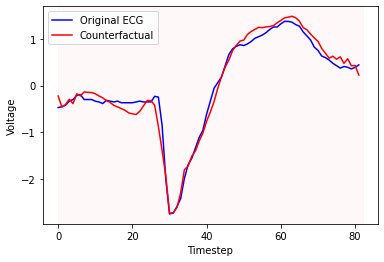

In [20]:
plt.figure(figsize=(6, 4))
plt.plot(original_sample, color='b', label="Original ECG")
plt.plot(cf_sample, color='r', label="Counterfactual")
plt.xlabel("Timestep")
plt.ylabel("Voltage")
plt.legend()
# plt.grid()
color = 'lightcoral' # if weight < 0 else 'green' 
plt.axvspan(0, 82, color=color, alpha=0.05)
plt.show()

In [23]:
print(z_pred[sample_id])

0.5005334


## NoAE search

In [24]:
###############################################
# ## 2.3 CF search with no autoencoder
###############################################
for pred_margin_weight in PRED_MARGIN_W_LIST:
    logger.info(f"The current prediction margin weight is {pred_margin_weight}.")

    # Get these instances of negative predictions, which is class abnormal (0); (normal is class 1)
    X_pred_neg = X_test_processed_padded[y_pred_classes == neg_label][:10]
    y_pred_labels = y_pred_classes[y_pred_classes==neg_label][:10]

    lr_list3 = [0.001]
    best_lr3, best_cf_model3, best_cf_samples3, _ = find_best_lr(
        classifier,
        X_pred_neg,
        y_pred_labels,
        autoencoder=None,
        lr_list=lr_list3,
        pred_margin_weight=pred_margin_weight,
        step_weights=step_weights,
        random_state=RANDOM_STATE,
    )
    print(f"The best learning rate found is {best_lr3}.")

    # ### Evaluation metrics
    # predicted probabilities of CFs
    z_pred3 = classifier.predict(best_cf_samples3)[:, 1]
    if padding_size != 0:
        # remove extra paddings after counterfactual generation
        best_cf_samples3 = best_cf_samples3[:, :-padding_size, :]
        # use the unpadded X for evaluation
        X_pred_neg_orignal = X_test_processed[y_pred_classes == neg_label][:10]
    else:
        X_pred_neg_orignal = X_pred_neg

    evaluate_res3 = evaluate(
        X_pred_neg_orignal, best_cf_samples3, z_pred3, n_timesteps
    )

    result_writer.write_result(
        "No autoencoder",
        acc,
        0,
        best_lr3,
        evaluate_res3,
        pred_margin_weight=pred_margin_weight,
        step_weight_type=w_type.lower(),
    )
    print(f"Done for CF search [No autoencoder], pred_margin_weight={pred_margin_weight}.")

======================== CF search started, with lr=0.001.
1 samples been transformed.
10 samples been transformed, in total.
1/1 [==============================] - 0s 31ms/step
lr=0.001 finished. Validity: 0.0, proximity: 0.13892636793655377.
The best learning rate found is 0.001.
1/1 [==============================] - 0s 30ms/step
Done for CF search [No autoencoder], pred_margin_weight=1.


In [25]:
# Uncomment to visualize the first 5 counterfactual samples
# Map the results back to the original scale, for comparison
actual_Xs = time_series_revert(X_pred_neg_orignal, n_timesteps=n_timesteps, scaler=trained_scaler)
actual_cfs3 = time_series_revert(best_cf_samples3, n_timesteps=n_timesteps, scaler=trained_scaler)

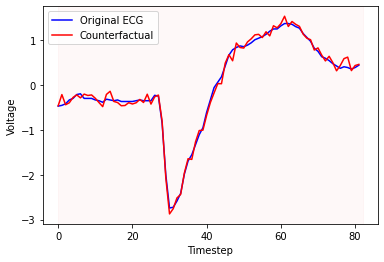

In [26]:
original_sample = actual_Xs[sample_id, :]
cf_sample = actual_cfs3[sample_id, :]

plt.figure(figsize=(6, 4))
plt.plot(original_sample, color='b', label="Original ECG")
plt.plot(cf_sample, color='r', label="Counterfactual")
plt.xlabel("Timestep")
plt.ylabel("Voltage")
plt.legend()
# plt.grid()
color = 'lightcoral' # if weight < 0 else 'green' 
plt.axvspan(0, 82, color=color, alpha=0.05)
plt.show()

In [29]:
print(z_pred3[sample_id])

0.5008773


## global, pred_margin_weight = 0.5

In [30]:
from _guided import get_global_weights
PRED_MARGIN_W_LIST = [0.5]
w_type = "uniform"

if w_type == "global":
    step_weights = get_global_weights(
        X_train_processed_padded,
        y_train_classes,
        classifier,
        random_state=RANDOM_STATE,
    )
elif w_type == "uniform":
    step_weights = np.ones((1, n_timesteps_padded, n_features))
elif w_type.lower() == "local":
    step_weights = "local"
else:
    raise NotImplementedError(
        "A.w_type not implemented, please choose 'local', 'global' or 'uniform'."
    )

### Evaluation metrics
for pred_margin_weight in PRED_MARGIN_W_LIST:
    logger.info(f"The current prediction margin weight is {pred_margin_weight}.")

    # Get these instances of negative predictions, which is class abnormal (0); (normal is class 1)
    X_pred_neg = X_test_processed_padded[y_pred_classes == neg_label][:10]
    y_pred_labels = y_pred_classes[y_pred_classes==neg_label][:10]

    lr_list = [0.0001]
    best_lr, best_cf_model, best_cf_samples, _ = find_best_lr(
        classifier,
        X_pred_neg,
        y_pred_labels,
        autoencoder=autoencoder,
        lr_list=lr_list,
        pred_margin_weight=pred_margin_weight,
        step_weights=step_weights,
        random_state=RANDOM_STATE,
    )
    print(f"The best learning rate found is {best_lr}.")

    # predicted probabilities of CFs
    z_pred = classifier.predict(best_cf_samples)[:, 1]
    if padding_size != 0:
        # remove extra paddings after counterfactual generation in 1dCNN autoencoder
        best_cf_samples = best_cf_samples[:, :-padding_size, :]
        # use the unpadded X for evaluation
        X_pred_neg_orignal = X_test_processed[y_pred_classes == neg_label][:10]
    else:
        X_pred_neg_orignal = X_pred_neg

    evaluate_res = evaluate(
        X_pred_neg_orignal, best_cf_samples, z_pred, n_timesteps
    )



======================== CF search started, with lr=0.0001.
1 samples been transformed.
10 samples been transformed, in total.
1/1 [==============================] - 0s 30ms/step
lr=0.0001 finished. Validity: 0.0, proximity: 0.16359383086258755.
The best learning rate found is 0.0001.
1/1 [==============================] - 0s 28ms/step


In [31]:
result_writer.write_result(
    "1dCNN autoencoder",
    acc,
    ae_val_loss,
    best_lr,
    evaluate_res,
    pred_margin_weight=pred_margin_weight,
    step_weight_type=w_type.lower(),
)
print(f"Done for CF search [1dCNN autoencoder], pred_margin_weight={pred_margin_weight}.")


Done for CF search [1dCNN autoencoder], pred_margin_weight=0.5.


In [32]:
# Uncomment to visualize the first 5 counterfactual samples
# Map the results back to the original scale, for comparison
actual_Xs = time_series_revert(X_pred_neg_orignal, n_timesteps=n_timesteps, scaler=trained_scaler)
actual_cfs = time_series_revert(best_cf_samples, n_timesteps=n_timesteps, scaler=trained_scaler)

### plot for TwoLeadECG

In [33]:
original_sample = actual_Xs[sample_id, :]
cf_sample = actual_cfs[sample_id, :]

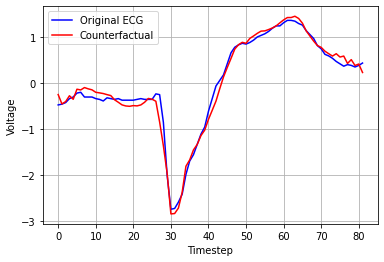

In [34]:
plt.figure(figsize=(6, 4))
plt.plot(original_sample, color='b', label="Original ECG")
plt.plot(cf_sample, color='r', label="Counterfactual")
plt.xlabel("Timestep")
plt.ylabel("Voltage")
plt.legend()
plt.grid()
plt.show()

In [54]:
print(z_pred[sample_id])

0.5006965


In [79]:
from wildboar.explain import *

class ModelWrapper:
    def __init__(self, model):
        self.model = model

    def predict(self, X):
        p = self.model.predict(X.reshape(X.shape[0], -1, 1))
        return np.argmax(p, axis=1) # I think this would work?

    def fit(self, X, y):
        return self.model.fit(X, y)

clf = ModelWrapper(classifier)
clf.fit(X_train_processed_padded.reshape(1,-1),y_train_classes)

i = IntervalImportance(scoring="accuracy", n_intervals=10, random_state=RANDOM_STATE)
i.fit(clf, X_train_processed_padded.reshape(X_train_processed_padded.shape[0], -1), y_train_classes)


ValueError: ignored

In [ ]:
print(i.importances_.mean)

In [ ]:
seg_idx = i.intervals_
seg_imp = i.importances_.mean

In [ ]:
# calculate the threshold of masking, 75 percentile
masking_threshold = np.percentile(seg_imp, 75)
# masking_threshold = np.percentile(i.importances_.mean, 25)
print(masking_threshold)
masking_idx = np.where(seg_imp >= masking_threshold)
print(masking_idx)
weighted_steps = np.ones(X_test_processed_padded.shape[1])
print(weighted_steps.shape)

for start_idx in masking_idx[0]:
    weighted_steps[seg_idx[start_idx][0] : seg_idx[start_idx][1]] = 0


In [ ]:
masking_threshold

In [ ]:
import math

plt.figure(figsize=(6, 4))
plt.plot(original_sample, color='b', label="Original ECG")
plt.plot(cf_sample, color='r', label="Counterfactual")
# plt.plot(np.mean(X_test[y_test_classes == 1], axis=0), color='green', label='Mean of other class')
# plt.legend(loc='lower left')
plt.xlabel("Timestep")
plt.ylabel("Voltage")
plt.legend()

for i in range(len(seg_idx)-1):
    weight = seg_imp[i]
    start = seg_idx[i][0]
    end = seg_idx[i+1][0] 
    print(f'{start}, {end}: {weight}')
    if weight <= masking_threshold: 
        continue
    color = 'lightcoral' # if weight < 0 else 'green' 
    plt.axvspan(start, end, color=color, alpha=abs(weight)*0.5)
plt.xlabel("Timestep")
plt.ylabel("Voltage")
# plt.grid()
plt.show()
    

## NoAE search

In [ ]:
###############################################
# ## 2.3 CF search with no autoencoder
###############################################
for pred_margin_weight in PRED_MARGIN_W_LIST:
    logger.info(f"The current prediction margin weight is {pred_margin_weight}.")

    # Get these instances of negative predictions, which is class abnormal (0); (normal is class 1)
    X_pred_neg = X_test_processed_padded[y_pred_classes == neg_label][:10]
    y_pred_labels = y_pred_classes[y_pred_classes==neg_label][:10]

    lr_list3 = [0.001]
    best_lr3, best_cf_model3, best_cf_samples3, _ = find_best_lr(
        classifier,
        X_pred_neg,
        y_pred_labels,
        autoencoder=None,
        lr_list=lr_list3,
        pred_margin_weight=pred_margin_weight,
        step_weights=step_weights,
        random_state=RANDOM_STATE,
    )
    print(f"The best learning rate found is {best_lr3}.")

    # ### Evaluation metrics
    # predicted probabilities of CFs
    z_pred3 = classifier.predict(best_cf_samples3)[:, 1]
    if padding_size != 0:
        # remove extra paddings after counterfactual generation
        best_cf_samples3 = best_cf_samples3[:, :-padding_size, :]
        # use the unpadded X for evaluation
        X_pred_neg_orignal = X_test_processed[y_pred_classes == neg_label][:10]
    else:
        X_pred_neg_orignal = X_pred_neg

    evaluate_res3 = evaluate(
        X_pred_neg_orignal, best_cf_samples3, z_pred3, n_timesteps
    )

    result_writer.write_result(
        "No autoencoder",
        acc,
        0,
        best_lr3,
        evaluate_res3,
        pred_margin_weight=pred_margin_weight,
        step_weight_type=w_type.lower(),
    )
    print(f"Done for CF search [No autoencoder], pred_margin_weight={pred_margin_weight}.")

In [ ]:
# Uncomment to visualize the first 5 counterfactual samples
# Map the results back to the original scale, for comparison
actual_Xs = time_series_revert(X_pred_neg_orignal, n_timesteps=n_timesteps, scaler=trained_scaler)
actual_cfs3 = time_series_revert(best_cf_samples3, n_timesteps=n_timesteps, scaler=trained_scaler)

In [ ]:
original_sample = actual_Xs[sample_id, :]
cf_sample = actual_cfs3[sample_id, :]

plt.figure(figsize=(6, 4))
plt.plot(original_sample, color='b', label="Original ECG")
plt.plot(cf_sample, color='r', label="Counterfactual")
# plt.plot(np.mean(X_test[y_test_classes == 1], axis=0), color='green', label='Mean of other class')
# plt.legend(loc='lower left')
plt.xlabel("Timestep")
plt.ylabel("Voltage")
plt.legend()

for i in range(len(seg_idx)-1):
    weight = seg_imp[i]
    start = seg_idx[i][0]
    end = seg_idx[i+1][0] 
    print(f'{start}, {end}: {weight}')
    if weight <= masking_threshold: 
        continue
    color = 'lightcoral' # if weight < 0 else 'green' 
    plt.axvspan(start, end, color=color, alpha=abs(weight)*0.5)
plt.xlabel("Timestep")
plt.ylabel("Voltage")
# plt.grid()
plt.show()
    

In [ ]:
original_sample = actual_Xs[sample_id, :]
cf_sample = actual_cfs3[sample_id, :]

plt.figure(figsize=(6, 4))
plt.plot(original_sample, color='b', label="Original ECG")
plt.plot(cf_sample, color='r', label="Counterfactual")
plt.xlabel("Timestep")
plt.ylabel("Voltage")
plt.legend()
# plt.grid()
plt.show()

In [ ]:
step_weights.reshape(-1)

In [ ]:
print(z_pred3[sample_id])

## local, pred_margin_weight = 0.5

In [ ]:
from _guided import get_global_weights
PRED_MARGIN_W_LIST = [0.5]
w_type = "local"

if w_type == "global":
    step_weights = get_global_weights(
        X_train_processed_padded,
        y_train_classes,
        classifier,
        random_state=RANDOM_STATE,
    )
elif w_type == "uniform":
    step_weights = np.ones((1, n_timesteps_padded, n_features))
elif w_type.lower() == "local":
    step_weights = "local"
else:
    raise NotImplementedError(
        "A.w_type not implemented, please choose 'local', 'global' or 'uniform'."
    )

### Evaluation metrics
for pred_margin_weight in PRED_MARGIN_W_LIST:
    logger.info(f"The current prediction margin weight is {pred_margin_weight}.")

    # Get these instances of negative predictions, which is class abnormal (0); (normal is class 1)
    X_pred_neg = X_test_processed_padded[y_pred_classes == neg_label][:10]
    y_pred_labels = y_pred_classes[y_pred_classes==neg_label][:10]

    lr_list = [0.0001]
    best_lr, best_cf_model, best_cf_samples, _ = find_best_lr(
        classifier,
        X_pred_neg,
        y_pred_labels,
        autoencoder=autoencoder,
        lr_list=lr_list,
        pred_margin_weight=pred_margin_weight,
        step_weights=step_weights,
        random_state=RANDOM_STATE,
    )
    print(f"The best learning rate found is {best_lr}.")

    # predicted probabilities of CFs
    z_pred = classifier.predict(best_cf_samples)[:, 1]
    if padding_size != 0:
        # remove extra paddings after counterfactual generation in 1dCNN autoencoder
        best_cf_samples = best_cf_samples[:, :-padding_size, :]
        # use the unpadded X for evaluation
        X_pred_neg_orignal = X_test_processed[y_pred_classes == neg_label][:10]
    else:
        X_pred_neg_orignal = X_pred_neg[:10]

    evaluate_res = evaluate(
        X_pred_neg_orignal, best_cf_samples, z_pred, n_timesteps
    )



In [ ]:
result_writer.write_result(
    "1dCNN autoencoder",
    acc,
    ae_val_loss,
    best_lr,
    evaluate_res,
    pred_margin_weight=pred_margin_weight,
    step_weight_type=w_type.lower(),
)
print(f"Done for CF search [1dCNN autoencoder], pred_margin_weight={pred_margin_weight}.")


In [ ]:
# Uncomment to visualize the first 5 counterfactual samples
# Map the results back to the original scale, for comparison
actual_Xs = time_series_revert(X_pred_neg_orignal, n_timesteps=n_timesteps, scaler=trained_scaler)
actual_cfs = time_series_revert(best_cf_samples, n_timesteps=n_timesteps, scaler=trained_scaler)

### plot for TwoLeadECG

In [ ]:
original_sample = actual_Xs[sample_id, :]
cf_sample = actual_cfs[sample_id, :]

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(original_sample, color='b', label="Original ECG")
plt.plot(cf_sample, color='r', label="Counterfactual")
plt.xlabel("Timestep")
plt.ylabel("Voltage")
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(z_pred[sample_id])

In [ ]:
from LIMESegment.Utils.explanations import LIMESegment

series = X_pred_neg[sample_id]

seg_imp, seg_idx = LIMESegment(
        series,
        classifier,
        model_type=1,
        cp=10,
        window_size=10,
        random_state=RANDOM_STATE,
    )

In [ ]:
# seg_imp, seg_idx = explanations
total_len = len(series)
seg_idx[-1] = total_len - padding_size
# seg_idx[-1] = total_len

In [ ]:
# calculate the threshold of masking, 25 percentile
masking_threshold = np.percentile(seg_imp, 25)
masking_idx = np.where(seg_imp <= masking_threshold)

masking_threshold

In [ ]:
import math

plt.figure(figsize=(6, 4))
plt.plot(original_sample, color='b', label="Original ECG")
plt.plot(cf_sample, color='r', label="Counterfactual")
# plt.plot(np.mean(X_test[y_test_classes == 1], axis=0), color='green', label='Mean of other class')
# plt.legend(loc='lower left')
plt.xlabel("Timestep")
plt.ylabel("Voltage")
plt.legend(loc='upper left')

for i in range(len(seg_idx)-1):
    weight = seg_imp[i]
    start = seg_idx[i]
    end = seg_idx[i+1] 
    print(f'{start}, {end}: {weight}')
    if weight >= masking_threshold: 
        continue
    color = 'lightcoral' #if weight < 0 else 'green' 
    plt.axvspan(start, end, color=color, alpha=0.11)#abs(weight))
plt.xlabel("Timestep")
plt.ylabel("Voltage")
# plt.grid()
plt.show()

In [ ]:
from LIMESegment.Utils.explanations import LIMESegment

def get_local_weights(input_sample, classifier_model, random_state=None):
    n_timesteps, n_dims = input_sample.shape  # n_dims=1
    seg_imp, seg_idx = LIMESegment(
        input_sample,
        classifier_model,
        model_type=1,
        cp=10,
        window_size=10,
        random_state=random_state,
    )

    # calculate the threshold of masking, 25 percentile
    masking_threshold = np.percentile(seg_imp, 25)
    masking_idx = np.where(seg_imp <= masking_threshold)

    weighted_steps = np.ones(n_timesteps)
    for start_idx in masking_idx[0]:
        weighted_steps[seg_idx[start_idx] : seg_idx[start_idx + 1]] = 0

    # need to reshape for multiplication in `tf.math.multiply()`
    weighted_steps = weighted_steps.reshape(1, n_timesteps, n_dims)
    return weighted_steps

In [ ]:
series = X_pred_neg[sample_id]

step_weights = get_local_weights(
    series, classifier, random_state=RANDOM_STATE
)

In [ ]:
step_weights.reshape(-1)

## NoAE search

In [ ]:
###############################################
# ## 2.3 CF search with no autoencoder
###############################################
for pred_margin_weight in PRED_MARGIN_W_LIST:
    logger.info(f"The current prediction margin weight is {pred_margin_weight}.")

    # Get these instances of negative predictions, which is class abnormal (0); (normal is class 1)
    X_pred_neg = X_test_processed_padded[y_pred_classes == neg_label][:10]
    y_pred_labels = y_pred_classes[y_pred_classes==neg_label][:10]

    lr_list3 = [0.001]
    best_lr3, best_cf_model3, best_cf_samples3, _ = find_best_lr(
        classifier,
        X_pred_neg,
        y_pred_labels,
        autoencoder=None,
        lr_list=lr_list3,
        pred_margin_weight=pred_margin_weight,
        step_weights=step_weights,
        random_state=RANDOM_STATE,
    )
    print(f"The best learning rate found is {best_lr3}.")

    # ### Evaluation metrics
    # predicted probabilities of CFs
    z_pred3 = classifier.predict(best_cf_samples3)[:, 1]
    if padding_size != 0:
        # remove extra paddings after counterfactual generation
        best_cf_samples3 = best_cf_samples3[:, :-padding_size, :]
        # use the unpadded X for evaluation
        X_pred_neg_orignal = X_test_processed[y_pred_classes == neg_label][:10]
    else:
        X_pred_neg_orignal = X_pred_neg[:10]

    evaluate_res3 = evaluate(
        X_pred_neg_orignal, best_cf_samples3, z_pred3, n_timesteps
    )

    result_writer.write_result(
        "No autoencoder",
        acc,
        0,
        best_lr3,
        evaluate_res3,
        pred_margin_weight=pred_margin_weight,
        step_weight_type=w_type.lower(),
    )
    print(f"Done for CF search [No autoencoder], pred_margin_weight={pred_margin_weight}.")

In [ ]:
# Uncomment to visualize the first 5 counterfactual samples
# Map the results back to the original scale, for comparison
actual_Xs = time_series_revert(X_pred_neg_orignal, n_timesteps=n_timesteps, scaler=trained_scaler)
actual_cfs3 = time_series_revert(best_cf_samples3, n_timesteps=n_timesteps, scaler=trained_scaler)

In [ ]:
original_sample = actual_Xs[sample_id, :]
cf_sample = actual_cfs3[sample_id, :]

plt.figure(figsize=(6, 4))
plt.plot(original_sample, color='b', label="Original ECG")
plt.plot(cf_sample, color='r', label="Counterfactual")
# plt.plot(np.mean(X_test[y_test_classes == 1], axis=0), color='green', label='Mean of other class')
# plt.legend(loc='lower left')
plt.xlabel("Timestep")
plt.ylabel("Voltage")
plt.legend(loc='upper left')

for i in range(len(seg_idx)-1):
    weight = seg_imp[i]
    start = seg_idx[i]
    end = seg_idx[i+1] 
    print(f'{start}, {end}: {weight}')
    if weight >= masking_threshold: 
        continue
    color = 'lightcoral' #if weight < 0 else 'green' 
    plt.axvspan(start, end, color=color, alpha=0.11)#abs(weight))
plt.xlabel("Timestep")
plt.ylabel("Voltage")
# plt.grid()
plt.show()

In [ ]:
original_sample = actual_Xs[sample_id, :]
cf_sample = actual_cfs3[sample_id, :]

plt.figure(figsize=(6, 4))
plt.plot(original_sample, color='b', label="Original ECG")
plt.plot(cf_sample, color='r', label="Counterfactual")
plt.xlabel("Timestep")
plt.ylabel("Voltage")
plt.legend()
# plt.grid()
plt.show()

In [ ]:
print(z_pred3[sample_id])

## uniform, pred_margin_weight = 0.5

In [ ]:
from _guided import get_global_weights
PRED_MARGIN_W_LIST = [0.5]
w_type = "uniform"

if w_type == "global":
    step_weights = get_global_weights(
        X_train_processed_padded,
        y_train_classes,
        classifier,
        random_state=RANDOM_STATE,
    )
elif w_type == "uniform":
    step_weights = np.ones((1, n_timesteps_padded, n_features))
elif w_type.lower() == "local":
    step_weights = "local"
else:
    raise NotImplementedError(
        "A.w_type not implemented, please choose 'local', 'global' or 'uniform'."
    )

### Evaluation metrics
for pred_margin_weight in PRED_MARGIN_W_LIST:
    logger.info(f"The current prediction margin weight is {pred_margin_weight}.")

    # Get these instances of negative predictions, which is class abnormal (0); (normal is class 1)
    X_pred_neg = X_test_processed_padded[y_pred_classes == neg_label][:10]
    y_pred_labels = y_pred_classes[y_pred_classes==neg_label][:10]

    lr_list = [0.0001]
    best_lr, best_cf_model, best_cf_samples, _ = find_best_lr(
        classifier,
        X_pred_neg,
        y_pred_labels,
        autoencoder=autoencoder,
        lr_list=lr_list,
        pred_margin_weight=pred_margin_weight,
        step_weights=step_weights,
        random_state=RANDOM_STATE,
    )
    print(f"The best learning rate found is {best_lr}.")

    # predicted probabilities of CFs
    z_pred = classifier.predict(best_cf_samples)[:, 1]
    if padding_size != 0:
        # remove extra paddings after counterfactual generation in 1dCNN autoencoder
        best_cf_samples = best_cf_samples[:, :-padding_size, :]
        # use the unpadded X for evaluation
        X_pred_neg_orignal = X_test_processed[y_pred_classes == neg_label][:10]
    else:
        X_pred_neg_orignal = X_pred_neg[:10]

    evaluate_res = evaluate(
        X_pred_neg_orignal, best_cf_samples, z_pred, n_timesteps
    )



In [ ]:
result_writer.write_result(
    "1dCNN autoencoder",
    acc,
    ae_val_loss,
    best_lr,
    evaluate_res,
    pred_margin_weight=pred_margin_weight,
    step_weight_type=w_type.lower(),
)
print(f"Done for CF search [1dCNN autoencoder], pred_margin_weight={pred_margin_weight}.")


In [ ]:
# Uncomment to visualize the first 5 counterfactual samples
# Map the results back to the original scale, for comparison
actual_Xs = time_series_revert(X_pred_neg_orignal, n_timesteps=n_timesteps, scaler=trained_scaler)
actual_cfs = time_series_revert(best_cf_samples, n_timesteps=n_timesteps, scaler=trained_scaler)

### plot for TwoLeadECG

In [ ]:
original_sample = actual_Xs[sample_id, :]
cf_sample = actual_cfs[sample_id, :]

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(original_sample, color='b', label="Original ECG")
plt.plot(cf_sample, color='r', label="Counterfactual")
plt.xlabel("Timestep")
plt.ylabel("Voltage")
plt.legend()
# plt.grid()
plt.show()

In [ ]:
print(z_pred[sample_id])

## NoAE search

In [ ]:
###############################################
# ## 2.3 CF search with no autoencoder
###############################################
for pred_margin_weight in PRED_MARGIN_W_LIST:
    logger.info(f"The current prediction margin weight is {pred_margin_weight}.")

    # Get these instances of negative predictions, which is class abnormal (0); (normal is class 1)
    X_pred_neg = X_test_processed_padded[y_pred_classes == neg_label][:10]
    y_pred_labels = y_pred_classes[y_pred_classes==neg_label][:10]

    lr_list3 = [0.001]
    best_lr3, best_cf_model3, best_cf_samples3, _ = find_best_lr(
        classifier,
        X_pred_neg,
        y_pred_labels,
        autoencoder=None,
        lr_list=lr_list3,
        pred_margin_weight=pred_margin_weight,
        step_weights=step_weights,
        random_state=RANDOM_STATE,
    )
    print(f"The best learning rate found is {best_lr3}.")

    # ### Evaluation metrics
    # predicted probabilities of CFs
    z_pred3 = classifier.predict(best_cf_samples3)[:, 1]
    if padding_size != 0:
        # remove extra paddings after counterfactual generation
        best_cf_samples3 = best_cf_samples3[:, :-padding_size, :]
        # use the unpadded X for evaluation
        X_pred_neg_orignal = X_test_processed[y_pred_classes == neg_label][:10]
    else:
        X_pred_neg_orignal = X_pred_neg[:10]

    evaluate_res3 = evaluate(
        X_pred_neg_orignal, best_cf_samples3, z_pred3, n_timesteps
    )

    result_writer.write_result(
        "No autoencoder",
        acc,
        0,
        best_lr3,
        evaluate_res3,
        pred_margin_weight=pred_margin_weight,
        step_weight_type=w_type.lower(),
    )
    print(f"Done for CF search [No autoencoder], pred_margin_weight={pred_margin_weight}.")

In [ ]:
# Uncomment to visualize the first 5 counterfactual samples
# Map the results back to the original scale, for comparison
actual_Xs = time_series_revert(X_pred_neg_orignal, n_timesteps=n_timesteps, scaler=trained_scaler)
actual_cfs3 = time_series_revert(best_cf_samples3, n_timesteps=n_timesteps, scaler=trained_scaler)

In [ ]:
original_sample = actual_Xs[sample_id, :]
cf_sample = actual_cfs3[sample_id, :]

plt.figure(figsize=(6, 4))
plt.plot(original_sample, color='b', label="Original ECG")
plt.plot(cf_sample, color='r', label="Counterfactual")
plt.xlabel("Timestep")
plt.ylabel("Voltage")
plt.legend()
# plt.grid()
plt.show()

In [ ]:
step_weights.reshape(-1)

In [ ]:
print(z_pred3[sample_id])